In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Load the dataset
file_path = 'Updated_Merged_Data_test.csv'
data = pd.read_csv(file_path)

# List of remote sensing variables
remote_sensing_vars = [col for col in data.columns if '_B' in col]

# List of average variables
avg_vars = ['B2_AVG', 'B3_AVG', 'B4_AVG', 'B8_AVG', 'B8A_AVG', 'B11_AVG', 'B12_AVG']

# List of cloud score variables
cloud_score_vars = [col for col in data.columns if '_cs' in col or '_cs_cdf' in col]

def plot_data(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero):
    plt.figure(figsize=(15, 6))
    
    # Evaluate the custom variable expression if provided
    if custom_var_expr:
        try:
            data['custom_var'] = eval(custom_var_expr, {"data": data, "np": np})
            x_var = 'custom_var'
        except Exception as e:
            print(f"Error in custom variable expression: {e}")
            return
    
    # Determine if the selected variable is a remote sensing variable or average variable
    is_remote_sensing = any(var in remote_sensing_vars for var in [x_var, y_var])
    is_avg = any(var in avg_vars for var in [x_var, y_var])
    
    if is_remote_sensing or is_avg:
        # Identify the point number from the variable name
        point_num = x_var.split('_')[0].replace('point', '') if 'custom_var' not in x_var else 'custom'
        if is_avg:
            cs_col = f'cs_AVG'
            cdf_col = f'cs_cdf_AVG'
        else:
            # Determine the corresponding cloud score column
            cs_col = f'point{point_num}_cs' if point_num != 'custom' else f'cs_AVG'
            cdf_col = f'point{point_num}_cs_cdf' if point_num != 'custom' else f'cs_cdf_AVG'
        
        # Filter out rows with NaN values in the selected columns
        if y_var != 'None':
            plot_data = data[[x_var, y_var, cs_col, cdf_col]].dropna()
        else:
            plot_data = data[[x_var, cs_col, cdf_col]].dropna()
        
        # Apply cloud score filtering if enabled
        if filter_cloud:
            plot_data = plot_data[(plot_data[cs_col] < cloud_threshold) & (plot_data[cdf_col] < cloud_threshold)]
    else:
        # Filter out rows with NaN values in the selected columns without cloud score filtering
        if y_var != 'None':
            plot_data = data[[x_var, y_var]].dropna()
        else:
            plot_data = data[[x_var]].dropna()
    
    # Drop zero-valued data points if enabled
    if drop_zero:
        plot_data = plot_data[(plot_data[x_var] != 0)]
        if y_var != 'None':
            plot_data = plot_data[(plot_data[y_var] != 0)]
    
    # Convert timestamp to datetime if present
    if 'timestamp_sentinel2' in data.columns:
        plot_data['timestamp_sentinel2'] = pd.to_datetime(data['timestamp_sentinel2'])
    
    # Add a small positive constant to avoid log(0) or negative values
    epsilon = 1e-10
    
    if plot_type == 'Scatter Plot':
        if log_x:
            plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
        if y_var != 'None' and log_y:
            plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
        if y_var != 'None':
            plt.scatter(plot_data[x_var], plot_data[y_var], alpha=0.5)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            
            # Calculate and display the correlation
            correlation = plot_data[[x_var, y_var]].corr().iloc[0, 1]
            plt.title(f'{plot_type} of {x_var} and {y_var}\nCorrelation: {correlation:.2f}')
        else:
            plt.scatter(plot_data.index, plot_data[x_var], alpha=0.5)
            plt.xlabel('Index')
            plt.ylabel(x_var)
            plt.title(f'{plot_type} of {x_var}')
        
    elif plot_type == 'Time Series Plot':
        if log_x:
            plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
        if y_var != 'None':
            fig, ax1 = plt.subplots(figsize=(15, 6))
            color = 'tab:blue'
            ax1.set_xlabel('Time')
            ax1.set_ylabel(x_var, color=color)
            ax1.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), color=color, label=f'{x_var} (Moving Average)')
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            if log_y:
                plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
            ax2.set_ylabel(y_var, color=color)
            ax2.plot(plot_data['timestamp_sentinel2'], plot_data[y_var].rolling(window=window).mean(), color=color, label=f'{y_var} (Moving Average)')
            ax2.tick_params(axis='y', labelcolor=color)
            
            fig.legend(loc='upper right')
            plt.title(f'{plot_type} of {x_var} and {y_var}')
        else:
            plt.figure(figsize=(15, 6))
            plt.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), label=f'{x_var} (Moving Average)')
            plt.xlabel('Time')
            plt.ylabel(x_var)
            plt.legend()
            plt.title(f'{plot_type} of {x_var}')
            
    plt.grid(True)
    plt.show()

variables = data.columns.tolist()
if 'timestamp_sentinel2' in variables:
    variables.remove('timestamp_sentinel2')

interact(plot_data, 
         plot_type=widgets.RadioButtons(options=['Scatter Plot', 'Time Series Plot'], description='Plot Type'),
         x_var=widgets.Dropdown(options=variables, description='X Variable'),
         y_var=widgets.Dropdown(options=['None'] + variables, description='Y Variable'),
         log_x=widgets.Checkbox(value=False, description='Log X Variable'),
         log_y=widgets.Checkbox(value=False, description='Log Y Variable'),
         window=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Moving Avg Window'),
         filter_cloud=widgets.Checkbox(value=False, description='Filter by Cloud Score'),
         cloud_band=widgets.RadioButtons(options=['cs', 'cs_cdf'], description='Cloud Band'),
         cloud_threshold=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Cloud Threshold'),
         custom_var_expr=widgets.Text(value='', description='Custom Var Expr'),
         drop_zero=widgets.Checkbox(value=False, description='Drop Zero Values')
);


<Figure size 1500x600 with 0 Axes>

interactive(children=(RadioButtons(description='Plot Type', options=('Scatter Plot', 'Time Series Plot'), valu…

<Figure size 1500x600 with 0 Axes>

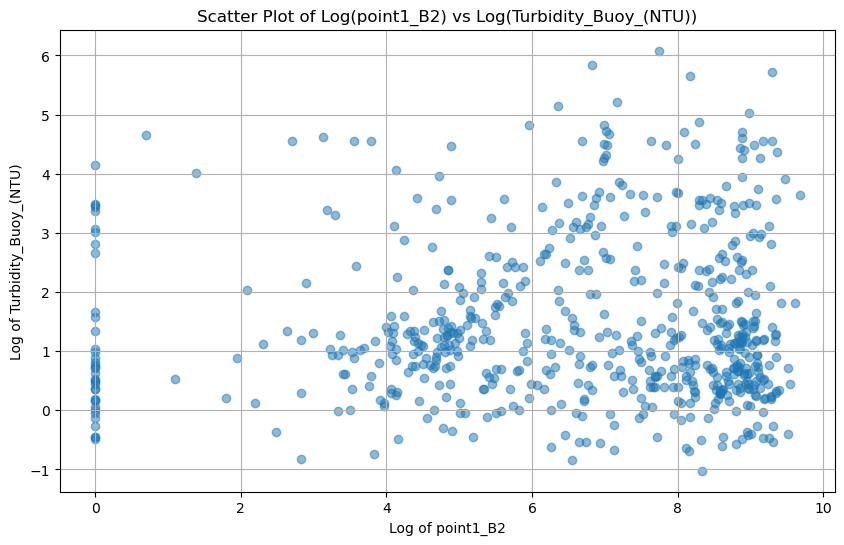

In [5]:


# Define the two columns you want to plot
x_col = 'point1_B2'  # Replace with your actual column name
y_col = 'Turbidity_Buoy_(NTU)'  # Replace with your actual column name

# Drop rows with NaN values in the selected columns
plot_data = data[[x_col, y_col]].dropna()
# Drop zero values
plot_data = plot_data[(plot_data[x_col] != 0) & (plot_data[y_col] != 0)]

# Take the logarithm of the values
epsilon = 1e-10  # Small constant to avoid log(0)
plot_data[x_col] = np.log(plot_data[x_col] + epsilon)
plot_data[y_col] = np.log(plot_data[y_col] + epsilon)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_data[x_col], plot_data[y_col], alpha=0.5)
plt.xlabel(f'Log of {x_col}')
plt.ylabel(f'Log of {y_col}')
plt.title(f'Scatter Plot of Log({x_col}) vs Log({y_col})')
plt.grid(True)
plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Load the dataset
file_path = 'Updated_Merged_Data_test.csv'
data = pd.read_csv(file_path)

# List of remote sensing variables
remote_sensing_vars = [col for col in data.columns if '_B' in col]

# List of average variables
avg_vars = ['B2_AVG', 'B3_AVG', 'B4_AVG', 'B8_AVG', 'B8A_AVG', 'B11_AVG', 'B12_AVG']

# List of cloud score variables
cloud_score_vars = [col for col in data.columns if '_cs' in col or '_cs_cdf' in col]

def plot_data(plot_type, x_var, y_var, log_x, log_y, window, filter_cloud, cloud_band, cloud_threshold, custom_var_expr, drop_zero):
    plt.figure(figsize=(15, 6))
    
    # Evaluate the custom variable expression if provided
    if custom_var_expr:
        try:
            data['custom_var'] = eval(custom_var_expr, {"data": data, "np": np})
            x_var = 'custom_var'
        except Exception as e:
            print(f"Error in custom variable expression: {e}")
            return
    
    # Determine if the selected variable is a remote sensing variable or average variable
    is_remote_sensing = any(var in remote_sensing_vars for var in [x_var, y_var])
    is_avg = any(var in avg_vars for var in [x_var, y_var])
    
    if is_remote_sensing or is_avg:
        # Extract coordinates from the variable name
        if 'custom_var' not in x_var:
            coords = '_'.join(x_var.split('_')[1:-1])
        else:
            coords = 'custom'
        
        if is_avg:
            cs_col = 'cs_AVG'
            cdf_col = 'cs_cdf_AVG'
        else:
            # Determine the corresponding cloud score column
            cs_col = f'unknown_{coords}_cs' if coords != 'custom' else 'cs_AVG'
            cdf_col = f'unknown_{coords}_cs_cdf' if coords != 'custom' else 'cs_cdf_AVG'
        
        # Filter out rows with NaN values in the selected columns
        if y_var != 'None':
            plot_data = data[[x_var, y_var, cs_col, cdf_col]].dropna()
        else:
            plot_data = data[[x_var, cs_col, cdf_col]].dropna()
        
        # Apply cloud score filtering if enabled
        if filter_cloud:
            plot_data = plot_data[(plot_data[cs_col] < cloud_threshold) & (plot_data[cdf_col] < cloud_threshold)]
    else:
        # Filter out rows with NaN values in the selected columns without cloud score filtering
        if y_var != 'None':
            plot_data = data[[x_var, y_var]].dropna()
        else:
            plot_data = data[[x_var]].dropna()
    
    # Drop zero-valued data points if enabled
    if drop_zero:
        plot_data = plot_data[(plot_data[x_var] != 0)]
        if y_var != 'None':
            plot_data = plot_data[(plot_data[y_var] != 0)]
    
    # Add a small positive constant to avoid log(0) or negative values
    epsilon = 1e-10
    
    # Take the logarithm of the values if enabled
    if log_x:
        plot_data[x_var] = np.log(plot_data[x_var] + epsilon)
    if y_var != 'None' and log_y:
        plot_data[y_var] = np.log(plot_data[y_var] + epsilon)
    
    if plot_type == 'Scatter Plot':
        if y_var != 'None':
            plt.scatter(plot_data[x_var], plot_data[y_var], alpha=0.5)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            
            # Calculate and display the correlation
            correlation = plot_data[[x_var, y_var]].corr().iloc[0, 1]
            plt.title(f'{plot_type} of {x_var} and {y_var}\nCorrelation: {correlation:.2f}')
        else:
            plt.scatter(plot_data.index, plot_data[x_var], alpha=0.5)
            plt.xlabel('Index')
            plt.ylabel(x_var)
            plt.title(f'{plot_type} of {x_var}')
        
    elif plot_type == 'Time Series Plot':
        if y_var != 'None':
            fig, ax1 = plt.subplots(figsize=(15, 6))
            color = 'tab:blue'
            ax1.set_xlabel('Time')
            ax1.set_ylabel(x_var, color=color)
            ax1.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), color=color, label=f'{x_var} (Moving Average)')
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel(y_var, color=color)
            ax2.plot(plot_data['timestamp_sentinel2'], plot_data[y_var].rolling(window=window).mean(), color=color, label=f'{y_var} (Moving Average)')
            ax2.tick_params(axis='y', labelcolor=color)
            
            fig.legend(loc='upper right')
            plt.title(f'{plot_type} of {x_var} and {y_var}')
        else:
            plt.figure(figsize=(15, 6))
            plt.plot(plot_data['timestamp_sentinel2'], plot_data[x_var].rolling(window=window).mean(), label=f'{x_var} (Moving Average)')
            plt.xlabel('Time')
            plt.ylabel(x_var)
            plt.legend()
            plt.title(f'{plot_type} of {x_var}')
            
    plt.grid(True)
    plt.show()

variables = data.columns.tolist()
if 'timestamp_sentinel2' in variables:
    variables.remove('timestamp_sentinel2')

interact(plot_data, 
         plot_type=widgets.RadioButtons(options=['Scatter Plot', 'Time Series Plot'], description='Plot Type'),
         x_var=widgets.Dropdown(options=variables, description='X Variable'),
         y_var=widgets.Dropdown(options=['None'] + variables, description='Y Variable'),
         log_x=widgets.Checkbox(value=False, description='Log X Variable'),
         log_y=widgets.Checkbox(value=False, description='Log Y Variable'),
         window=widgets.IntSlider(value=5, min=1, max=50, step=1, description='Moving Avg Window'),
         filter_cloud=widgets.Checkbox(value=False, description='Filter by Cloud Score'),
         cloud_band=widgets.RadioButtons(options=['cs', 'cs_cdf'], description='Cloud Band'),
         cloud_threshold=widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Cloud Threshold'),
         custom_var_expr=widgets.Text(value='', description='Custom Var Expr'),
         drop_zero=widgets.Checkbox(value=False, description='Drop Zero Values')
);


interactive(children=(RadioButtons(description='Plot Type', options=('Scatter Plot', 'Time Series Plot'), valu…

<Figure size 1500x600 with 0 Axes>